# SVM 支援向量機
```
1. N維度中找到一個超平面(N-1)維，可以區分開兩類的點, 非線性的資料也可以分割, 不要用錯套件就好, EX: LinearSVC(擺明就是線性), 用錯就是效果差一點而已
2. 超平面的kernel function可以客製化, 前提是要能夠理解數學原理, kernel function是將分割函數映射到高維度空間的函式, sklearn有提供幾個, 預設是RBF(Radinal Base Function), 這裡提供官網範例, 這邊個人先不研究這麼深入, http://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#example-svm-plot-custom-kernel-py
3. 支援高維度的資料, 所以頗適合文章分類器, 適合2分法, 也可以一個svm分多個類別, 或是對於n類, 每個類別給個svm作2分法~
4. 參考資料: http://data-eater.com/svm-note/ 
            http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
```

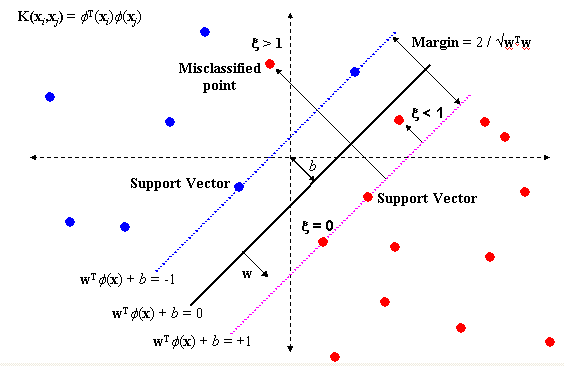

In [1]:
from IPython.display import Image
Image('svm.PNG')

如果對於現性不可分割的狀況, 就透過kernel function 增加維度映射到高維度的空間, 增加為度的高難度function sklearn幫你寫好了


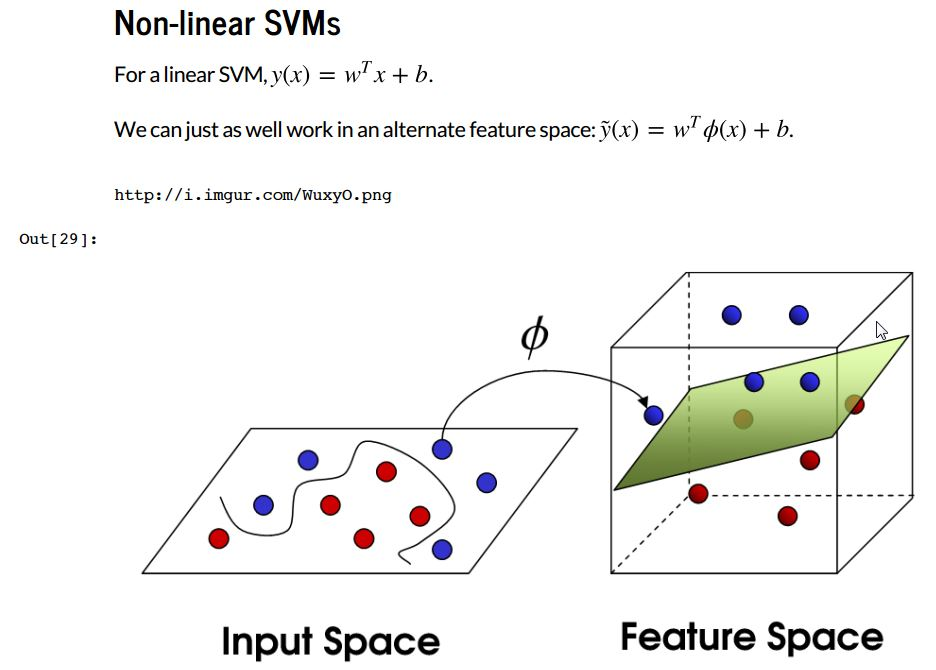

In [2]:
from IPython.display import Image
print('如果對於現性不可分割的狀況, 就透過kernel function 增加維度映射到高維度的空間, 增加為度的高難度function sklearn幫你寫好了')
Image('svm2.PNG')

In [1]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect('sklearnDs.sqlite') 

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [7]:
# 抓出頻果新聞資料
apple36Df, apple78Df = None, None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
    
    apple36Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160301_20160630_02
         order by batchno
    ''', sklearnConn)
apple36Df.head()

,forum,subject,term,keyword,content,pageurl
0,strange,農婦打噴嚏燒傷8頭驢 20萬飛了,山東 劉姓 農婦 打火機 編號 掛牌 噴嚏 倒楣 驢子 燒傷 人民幣 台幣 中國 齊魯 報導...,驢子 驢子 驢子 驢子 驢子 驢子 驢子 農婦 農婦 農婦 農婦 噴嚏 噴嚏 噴嚏 紋身 紋...,山東一名劉姓農婦，日前在用打火機替家中飼養的毛驢掛上編號掛牌時，忍不住打了個噴嚏，沒想到手一...,http://www.appledaily.com.tw/realtimenews/arti...
1,strange,最新款007座駕 日內瓦展前曝光,形象 英國 martin 旗下 十二 跑車 消息 國外 媒體 瑞士 時間 日內瓦 車展 推出...,車展 車展 新款 新款 優雅 優雅 力表 過動 渦輪引擎 曝光 曝光 渦輪 元則 端倪 ma...,形象與007專屬座駕密不可分的英國Aston Martin，旗下行之有年的DB9十二缸跑車，...,http://www.appledaily.com.tw/realtimenews/arti...
2,strange,上班族好無奈 最怕同事這些壞習慣,職場 同事 百款 上班族 星期 同事 時間 小時 小心 衛生習慣 公德心 習慣 同事 報導 ...,冰箱 冰箱 冰箱 同事 同事 同事 生氣 生氣 衛生習慣 百款 大吼大叫 易怒 公德心 公用...,職場同事百百款，身為一位上班族，一星期有5天必須跟同事見面，每天相處時間還得要8小時以上，如...,http://www.appledaily.com.tw/realtimenews/arti...
3,strange,【占卜】你為什麼想分手？,單身 相愛 分手 原因 家庭 壓力 第三者 金錢 工作 老師 數字 占卜 分手 原因 楊婷 ...,分手 分手 分手 分手 愛情 愛情 愛情 相愛 相愛 資料 資料 資料 資料 照片 照片 照...,你恢復單身了嗎？相愛容易相處難，會讓你想分手的原因是什麼呢？是家庭壓力、第三者、金錢還是工作...,http://www.appledaily.com.tw/realtimenews/arti...
4,strange,【旅途中】櫻花叢中的小精靈,櫻花 季節 發現 櫻花 雙活 眼睛 棲蘭 武陵農場 意外 漂亮 實在 可愛 小精靈 棲蘭 國...,棲蘭 棲蘭 櫻花 櫻花 櫻花 畫眉 畫眉 武陵農場 武陵農場 賞櫻 賞櫻 親子 親子 雙活 ...,春暖花開，又到了追櫻花的季節，有沒有發現粉嫩粉嫩的櫻花，幾雙活靈活現的的眼睛在盯著呢？愛玩姐...,http://www.appledaily.com.tw/realtimenews/arti...


In [4]:
# SGDClassifier的特性是... trainin data丟回去預測並不會100%正確, 
# 跟NaiveBayes不一樣... 所以看到範例把training data丟回給 SGDClassifier 打分數, 不要意外

# 1. 使用 3-6月 term當training data(88753), 7-8月當test data(36625)
# 2. 用 term field 為主
# 3. 官網說 SGDClassifier 是SVM中效果較好的實作, 這裡先試用他
#    Let’s see if we can do better with a linear support vector machine (SVM), 
#    which is widely regarded as one of the best text classification algorithms (although it’s also a bit slower than naïve Bayes)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

limit = len(apple36Df.term)

sgd = SGDClassifier(penalty="l2", alpha=0.001)
vec = TfidfVectorizer()
trainMx = vec.fit_transform(apple36Df.term)
sgd.fit(trainMx[:limit], apple36Df.forum[:limit])
predicted = sgd.predict(vec.transform(apple78Df.term))

print(metrics.classification_report(apple78Df.forum, predicted, target_names=sgd.classes_))
pd.DataFrame(columns=sgd.classes_, index=sgd.classes_, data=metrics.confusion_matrix(apple78Df.forum, predicted))

               precision    recall  f1-score   support

           3c       0.67      0.75      0.70       734
       animal       0.94      0.54      0.69       673
entertainment       0.82      0.86      0.84      3082
      fashion       0.87      0.73      0.79       649
      finance       0.83      0.81      0.82      3201
        forum       0.79      0.08      0.14      1052
international       0.79      0.89      0.84      7579
         life       0.78      0.75      0.76      7029
        local       0.74      0.90      0.81      4971
     politics       0.78      0.69      0.73      2543
     property       0.92      0.83      0.87       551
       sports       0.88      0.95      0.91      3441
      strange       0.75      0.52      0.62      1120

  avg / total       0.80      0.80      0.79     36625



,3c,animal,entertainment,fashion,finance,forum,international,life,local,politics,property,sports,strange
3c,548,3,16,0,40,0,21,47,11,0,0,7,41
animal,4,363,21,0,0,0,50,38,71,1,0,3,122
entertainment,16,1,2649,16,16,0,147,62,111,6,3,47,8
fashion,2,0,115,475,2,0,38,7,1,0,0,9,0
finance,45,0,27,6,2593,1,286,142,31,35,14,19,2
forum,10,1,26,0,50,81,338,232,64,199,3,45,3
international,41,5,51,0,84,2,6719,61,450,31,0,131,4
life,117,4,237,20,211,11,331,5250,578,133,8,115,14
local,19,0,12,0,19,6,78,287,4457,75,2,15,1
politics,1,0,14,0,64,1,259,249,174,1751,6,24,0


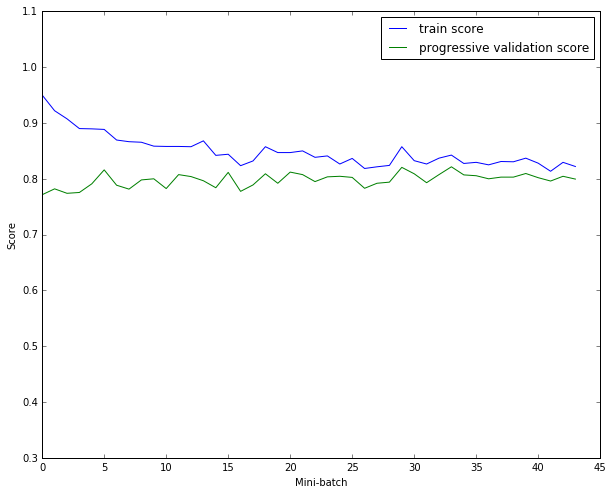

In [5]:
# 承上 apple 3-6月總共8萬多筆資料, 這裡利用 partial_fit的功能, 測試到底是不是要用到8萬筆的training data
# SGDClassifier的特性是... trainin data丟回去預測並不會100%正確, 
# 看綠色的曲線大概在 2000 * 25 = 五萬左右的之後, 比較穩定在0.8的精確度且和藍線比較靠近~
from sklearn.linear_model import SGDClassifier
est = SGDClassifier(penalty="l2", alpha=0.001)
progressive_validation_score = []
train_score = []
perBatch = 2000
for datapoint in range(0, trainMx.shape[0], perBatch):
    X_batch = trainMx[datapoint : datapoint+perBatch if datapoint+perBatch <= trainMx.shape[0] else trainMx.shape[0]]
    y_batch = apple36Df.forum.values[datapoint : datapoint+perBatch]
    if datapoint > 0:
        progressive_validation_score.append(est.score(X_batch, y_batch))
    est.partial_fit(X_batch, y_batch, classes=apple36Df.forum.unique())
    if datapoint > 0:
        train_score.append(est.score(X_batch, y_batch))
    
plt.figure(figsize=(10, 8))
plt.plot(train_score, label="train score")
plt.plot(progressive_validation_score, label="progressive validation score")
plt.ylim((0.3, 1.1))
plt.xlabel("Mini-batch")
plt.ylabel("Score")
plt.legend(loc='best')

In [57]:
# 1. 使用 3-6月 term當training data(88753), 7-8月當test data(36625)
# 2. 用 keyword field 為主, 跟term比起來, 準度下降很多
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

sgd = SGDClassifier(penalty="l2", alpha=0.001)
vec = TfidfVectorizer()
trainMx = vec.fit_transform(apple36Df.keyword.values)
sgd.fit(trainMx, apple36Df.forum)
predicted = sgd.predict(vec.transform(apple78Df.keyword))

print(metrics.classification_report(apple78Df.forum, predicted, target_names=sgd.classes_))
pd.DataFrame(columns=sgd.classes_, index=sgd.classes_, data=metrics.confusion_matrix(apple78Df.forum, predicted))

               precision    recall  f1-score   support

           3c       0.50      0.60      0.55       734
       animal       0.88      0.56      0.68       673
entertainment       0.78      0.78      0.78      3082
      fashion       0.77      0.72      0.74       649
      finance       0.74      0.79      0.76      3201
        forum       0.70      0.03      0.05      1052
international       0.72      0.73      0.73      7579
         life       0.71      0.71      0.71      7029
        local       0.64      0.85      0.73      4971
     politics       0.75      0.66      0.70      2543
     property       0.86      0.55      0.67       551
       sports       0.84      0.92      0.88      3441
      strange       0.63      0.29      0.39      1120

  avg / total       0.73      0.72      0.71     36625



,3c,animal,entertainment,fashion,finance,forum,international,life,local,politics,property,sports,strange
3c,444,3,34,5,80,1,27,71,32,2,0,11,24
animal,2,378,26,0,4,0,66,48,67,4,0,2,76
entertainment,20,3,2408,24,30,0,287,85,151,10,0,56,8
fashion,1,0,92,470,5,0,56,9,3,0,0,11,2
finance,87,1,23,11,2520,1,246,175,41,38,15,33,10
forum,15,3,30,1,64,28,331,227,88,206,4,51,4
international,101,19,109,7,188,2,5554,253,1040,70,3,213,20
life,161,9,249,31,238,3,382,5017,621,124,16,139,39
local,30,5,29,1,49,5,146,382,4218,84,2,17,3
politics,5,0,12,0,76,0,291,267,178,1682,6,26,0


In [ ]:
# SGDClassifier 換成 SVC後, 這一段已經跑不出來了, 執行前請三思...
# (官網有提到這點..., train文章數量 > 向量維度 [n_smaples > n_vectors], 效能會很差)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn import metrics
from sklearn import metrics

sgd = SVC(kernel='linear')
vec = TfidfVectorizer()
trainMx = vec.fit_transform(apple36Df.term.values)
sgd.fit(trainMx, apple36Df.forum)
predicted = sgd.predict(vec.transform(apple78Df.term))

print(metrics.classification_report(apple78Df.forum, predicted, target_names=sgd.classes_))
pd.DataFrame(columns=sgd.classes_, index=sgd.classes_, data=metrics.confusion_matrix(apple78Df.forum, predicted))

In [3]:
help(SelectKBest)

Help on class SelectKBest in module sklearn.feature_selection.univariate_selection:

class SelectKBest(_BaseFilter)
 |  Select features according to the k highest scores.
 |  
 |  Read more in the :ref:`User Guide <univariate_feature_selection>`.
 |  
 |  Parameters
 |  ----------
 |  score_func : callable
 |      Function taking two arrays X and y, and returning a pair of arrays
 |      (scores, pvalues) or a single array with scores.
 |      Default is f_classif (see below "See also"). The default function only
 |      works with classification tasks.
 |  
 |  k : int or "all", optional, default=10
 |      Number of top features to select.
 |      The "all" option bypasses selection, for use in a parameter search.
 |  
 |  Attributes
 |  ----------
 |  scores_ : array-like, shape=(n_features,)
 |      Scores of features.
 |  
 |  pvalues_ : array-like, shape=(n_features,)
 |      p-values of feature scores, None if `score_func` returned only scores.
 |  
 |  Notes
 |  -----
 |  Ties 

In [1]:
# 附錄: 特徵值選取, 這邊他用f_regression去選取每筆資料最好的3個feature, 用textmining來想就是每篇文章找出最具代表性的3個關鍵字
# 不過感覺似乎tfidf, text rank, 或是entropy去過濾是否會比較直觀?

from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline

X, y = samples_generator.make_classification(
    n_features=20, n_informative=3, n_redundant=0, n_classes=4,
    n_clusters_per_class=2)
print(X)
print(y)

# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=3)
# 2) svm
clf = svm.SVC(kernel='linear')

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X, y)
pred = anova_svm.predict(X)

from sklearn.metrics import accuracy_score
accuracy_score(y, pred)

[[ 0.2905375  -1.0486734   0.77858235 ..., -0.45587255  0.34737104
  -0.66112112]
 [ 0.20350151  1.11576161  0.55407198 ...,  1.08789381 -0.07435379
  -1.00647346]
 [-0.87387303  0.67970396  0.35096647 ..., -0.43283288 -1.25918731
  -1.06751285]
 ..., 
 [-0.08883444 -1.18996117 -0.36122061 ...,  0.04787731  0.70780409
   0.42799892]
 [ 0.36538046 -2.2213249  -1.32663144 ...,  0.08735651  1.11394317
   0.48587519]
 [-0.51416248  1.49206665 -0.97729021 ...,  0.35734125 -0.01121661
   1.17353309]]
[2 3 1 0 3 1 2 3 3 1 2 2 2 2 3 0 2 0 0 2 1 0 1 1 2 1 1 3 3 2 1 0 1 2 3 3 1
 1 2 1 3 0 2 3 3 3 3 0 3 2 0 1 0 2 0 0 3 2 1 1 0 1 3 2 2 0 3 2 3 2 0 3 1 0
 3 0 0 2 2 1 1 0 1 0 0 1 2 1 2 3 0 2 0 3 1 0 1 0 2 3]


0.71999999999999997

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(trainMx[:2000].toarray())
pca

PCA(copy=True, n_components=2, whiten=False)

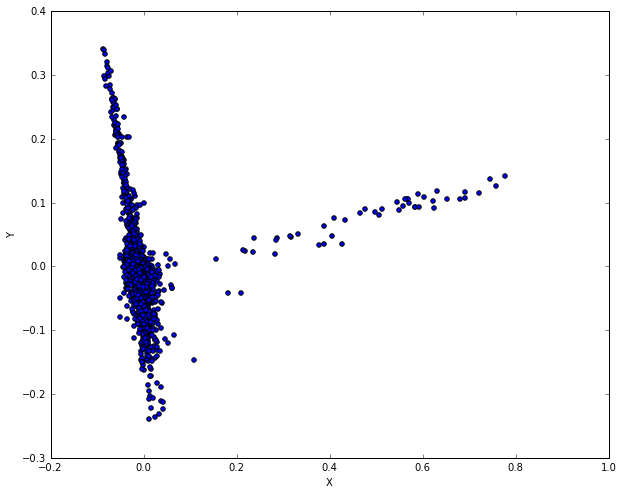

In [46]:
# 使用PCA降維度看看頻果新聞前2000筆文章的分布, 不過其實也看不出什麼端倪
from sklearn.decomposition import PCA
oridata = trainMx[:2000].toarray()

pca = PCA(n_components=2).fit(oridata)
data = pca.transform(oridata)
plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1])
# plt.scatter(progressive_validation_score, label="progressive validation score")
# plt.ylim((0.3, 1.1))
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='best')

The best parameters are {'C': 1.0, 'gamma': 0.10000000000000001} with a score of 0.97


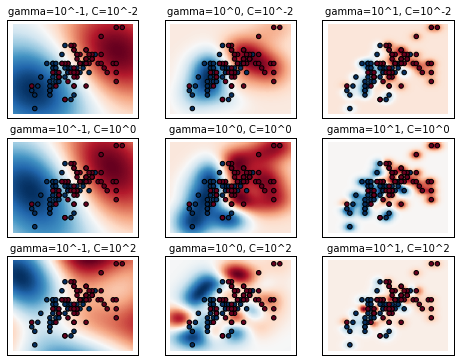

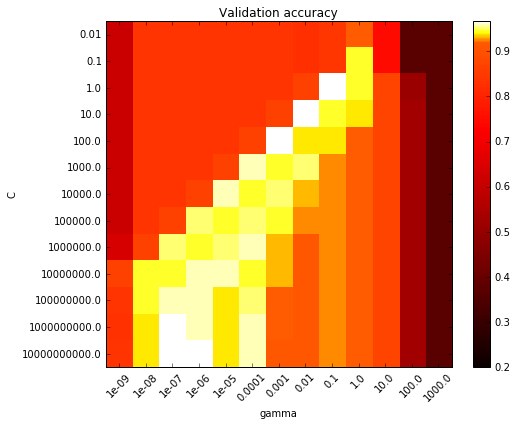

In [44]:
# 官網範例: SVM最重要兩個參數調整是 gamma, C(不過kernel不是linear, 是rbf), 範例顯示如何去找這兩個最佳化的數字(用GridSearchCV), 提升分類器準確度
# 畫圖部分的程式碼有點複雜, 看不懂可以先略過

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV


# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

##############################################################################
# Load and prepare data set
#
# dataset for grid search

iris = load_iris()
X = iris.data
y = iris.target

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

##############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

##############################################################################
# visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
# We extract just the scores
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()
